In [1]:
import os
import sys
import numpy as np 

import json
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


def Area_under_the_curve(X, Y):
    X = X[:]
    Y = Y[:]
    dx = np.diff(X)
    X_ = np.array([])
    Y_ = np.array([])
    
    eps = 5e-3
    for i in range(len(dx)):
        if dx[i] > eps:
            x0 = X[i]; x1 = X[i+1]
            y0 = Y[i]; y1 = Y[i+1]
            a = (y1 - y0) / (x1 - x0)
            b = y0 - a * x0
            x = np.arange(x0, x1, eps)
            y = a * x + b                
            X_ = np.concatenate((X_, x))
            Y_ = np.concatenate((Y_, y))
        else:
            X_ = np.concatenate((X_, X[i:i+1]))
            Y_ = np.concatenate((Y_, Y[i:i+1]))
                    
    X_ = np.concatenate((X_, X[-1:]))
    Y_ = np.concatenate((Y_, Y[-1:]))
    
    new_dx = np.diff(X_)
    area = 100 * np.inner(Y_[:-1], new_dx)
    
    return area

def create_mAP(results_folders, labels, colors, output_path, graph_title, file_name):
# if __name__ == '__main__':
    file_name += '.png'
    fig = plt.figure()
    ax = plt.subplot(111)
#     Npoints = num_samples
    Interpolation = True
    Correct = True
    for rf in range(len(results_folders)):
        
#         print(results_folders[rf])
        with open(results_folders[rf], "r") as f:
            json_file = json.load(f)
        num_samples = len(np.array(json_file["rec"]))
        Npoints = num_samples
#         print(Npoints)
                
        recall = np.zeros((num_samples))
        precision = np.zeros((num_samples))
        
        MAP = 0
        
        recall_i = np.zeros((num_samples))
        precision_i = np.zeros((num_samples))
        
        AP_i = []
        AP_i_ = 0

        recall__ = np.array(json_file["rec"])
        precision__ = np.array(json_file["prec"])

        #print(precision__)
        #print(recall__)

        if np.size(recall__) > Npoints:
            recall__ = recall__[:]
        if np.size(precision__) > Npoints:
            precision__ = precision__[:-1]

        recall__ = recall__/100
        precision__ = precision__/100

        if Correct:

            if precision__[0] == 0: # Only when Precision is 0 as product of undefinitions
                precision__[0] = 2 * precision__[1] - precision__[2]                

            if Interpolation:
                precision = precision__[:]
                precision__[:] = np.maximum.accumulate(precision[::-1])[::-1]


            if recall__[0] > 0:
                recall = np.zeros((num_samples + 1))
                precision = np.zeros((num_samples + 1))
                # Replicating precision value
                precision[0] = precision__[0]
                precision[1:] = precision__
                precision__ = precision
                # Attending recall
                recall[1:] = recall__
                recall__ = recall


        #p = precision__[:,:-1]
        #dr = np.diff(recall__)

        recall_i = recall__
        precision_i = precision__
        
#         cubic_interp  = interp1d(recall_i, precision_i, kind='cubic')
#         interpolation_time = np.linspace(0, 1, 100)
#         print(interpolation_time)
#         linear_interp = interp1d(recall_i, precision_i)
#         cubic_results = cubic_interp(interpolation_time)
#         linear_results = linear_interp(interpolation_time)

        #mAP = 100 * np.matmul(p , np.transpose(dr))
        mAP = Area_under_the_curve(recall__, precision__)
        ax.plot(recall_i[:], precision_i[:],color=colors[rf], label=labels[rf] + 'mAP:' + str(np.round(mAP,1)))
        
#         ax.plot(interpolation_time, cubic_results, '--', color=colors[rf], label=labels[rf] + 'mAP:' + str(np.round(mAP,1)))
#         ax.plot(recall_i[:], precision_i[:], 'o',color=colors[rf], label=labels[rf] + 'mAP:' + str(np.round(mAP,1)))
        
        
    ax.legend()
    #plt.show()
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.grid(True)
    
    plt.title(graph_title)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    
    # let the graph perfectly squared
    plt.gca().set_aspect('equal', adjustable='box')
    # change legend location and font size
    plt.legend(bbox_to_anchor=(0.9, 1), prop={'size' : 8})
    
    plt.savefig(os.path.join(output_path, file_name), bbox_inches = 'tight')


In [2]:
def check_folders(path):
    if not os.path.isdir(path):
        return 0
    file_list = [f for f in os.listdir(path) if os.path.splitext(f)[1] == '.json']
#     print(len(file_list))
#     file_list = os.listdir(path)
    if len(file_list) > 1 or len(file_list) == 0:
        return 0
    else: 
        return os.path.join(path, file_list[0])

def check_labels(path):
    path = path.split('/')[-1]
    
    ## get source and target
    if path.split('_')[0] == 'og':
        path = path[3:]
    source = path.split('-')[0]
    target = path.split('-')[1].split('_')[0]
    if source[0] == 's':
        source = source[1:]
    if target[0] == 't':
        target = target[1:]
#     print("source", source)
#     print("target",target)
    
    ## get classifier and cyclegan name/paramters
    # parameters defined by folder name
    ftype = path.split('_')[1:]
    cyclegan_model = ftype[0]
    classifier_model = ftype[1]
#     print(ftype)
    
    ## older way to get classifier and cycle
    ftype = path.split('_')[1]
#     print(ftype)
    letter = ftype[0]
    number = ftype.split(letter)[1]
#     print (letter)
#     print(number)
    model = f'FT-{target}'
    if letter == 'A':
        model += "-CN"
    elif letter == 'B':
        model += "-CT"
    elif letter == 'D':
        model += "-CD"
        
    if number == '1':
        model += "-T"
    elif number == '2':
        model += "-P"
    elif number == '3':
        model += "-TP"
    elif number == '4':
        model += "-TPF"
    
    else:
        model += '_' + cyclegan_model + '_' + classifier_model
    model += f"({target})"
    
    return source, target, model, path, cyclegan_model, classifier_model

def get_title(source, target, network):
    title = 'S:'
    if source == 'PA':
        title += ' Amazon PA,'
    elif source == 'RO':
        title += ' Amazon RO,'
    elif source == 'MA':
        title += ' Cerrado MA, '
    
    if target == 'PA':
        title += ' T: Amazon PA'
    elif target == 'RO':
        title += ' T: Amazon RO'
    elif target == 'MA':
        title += ' T: Cerrado MA'
        
    if network != '':
        title += f' - {network}'
    
    return title

def run_all(experiments_path, list_of_folders, colors):
    for i in range(len(list_of_folders)):
        results_folders = []
        labels = []
        source, target, model, file_name, _, _ = check_labels(list_of_folders[i])

        results_folders.append(FS[f"{source}({target})"])
        results_folders.append(FS[f"{target}({target})"])

        labels.append(f"FS_{source}({target}); ")
        labels.append(f"FS_{target}({target}); ")
        labels.append(model + "; ")

        path = os.path.join(experiments_path, list_of_folders[i], default_results_folder)
        check = check_folders(path)
        if check !=0:
            results_folders.append(check)

        title = get_title(source, target, '')

        if len(results_folders) > 2:
            create_mAP(results_folders, labels, colors, output_path, title, file_name)

            
            
def check_network_is_equal(list_element, network):
    _, _, _, _, cyclegan, classifier = check_labels(list_element)
    if network == cyclegan or network == classifier:
        return True
    else:
        return False

def organize_list_by_classifier(result_list, label_list):
    order = ['_FS','_FP', '_FT', '_FTP', '_FTPF']
    out_result = []
    out_label = []
    list_size = len(label_list)
    for cf in order:
        #print(cf)
        for i in range(list_size):
            #print(label_list[i])
            if cf in label_list[i]:
                out_result.append(result_list[i])
                out_label.append(label_list[i])
                break
    #print("result_list:",out_result)
    #print("label_list:",out_label)
    return out_result, out_label    

    
def run_all_same_cyclegan(experiments_path, list_of_folders, colors):
    results_folders = []
    labels = []
    n_folders = len(list_of_folders)
    
    list_of_folders.sort()
    print("list size:",len(list_of_folders))
    print(list_of_folders)
    
    for i in range(n_folders):
        
        source, target, model, file_name, cyclegan, classifier = check_labels(list_of_folders[i])
        title = get_title(source, target, cyclegan)
        
        if i < n_folders-1:
            create_graph = not check_network_is_equal(list_of_folders[i+1], cyclegan)
        else:
            create_graph = True
            
        labels.append(model + "; ")
        path = os.path.join(experiments_path, list_of_folders[i], default_results_folder)
        check = check_folders(path)
        assert check != 0, "list_of_folders[i]"
        results_folders.append(check)
            
        if create_graph:
            file_name = file_name.split('_')[0] + '_' + file_name.split('_')[-2]
            results_folders, labels = organize_list_by_classifier(results_folders, labels)
            create_mAP(results_folders, labels, colors, output_path, title, file_name)
            results_folders = []
            labels = []

def organize_list_by_cyclegan(result_list, label_list):
    order = ['_CN_', '_CDNorm_', '_CT_', '_CTDNorm_']
    out_result = []
    out_label = []
    list_size = len(label_list)
    for cg in order:
        #print(cg)
        for i in range(list_size):
            #print(label_list[i])
            if cg in label_list[i]:
                out_result.append(result_list[i])
                out_label.append(label_list[i])
                break
    #print("result_list:",out_result)
    #print("label_list:",out_label)
    return out_result, out_label
            
def run_all_same_classifier(experiments_path, list_of_folders, colors):    
    results_folders = []
    labels = []
    n_folders = len(list_of_folders)
    
    list_of_folders.sort(key=lambda f: (f.split('_')[1], f.split('_')[-1]))
    print("list size:",len(list_of_folders))
    print(list_of_folders)
    
    for i in range(n_folders):
        
        source, target, model, file_name, cyclegan, classifier = check_labels(list_of_folders[i])
        title = get_title(source, target, classifier)
        
        if i < n_folders-1:
            create_graph = not check_network_is_equal(list_of_folders[i+1], classifier)
        else:
            create_graph = True
            
        labels.append(model + "; ")
        path = os.path.join(experiments_path, list_of_folders[i], default_results_folder)
        check = check_folders(path)
        assert check != 0, "list_of_folders[i]"
        results_folders.append(check)
            
        if create_graph:
            file_name = file_name.split('_')[0] + '_' + file_name.split('_')[-1]
            results_folders, labels = organize_list_by_cyclegan(results_folders, labels)
            create_mAP(results_folders, labels, colors, output_path, title, file_name)
            results_folders = []
            labels = []
            
            


In [3]:
# this_folder = "og_sRO-tMA_CDNorm_FP"
# label = check_labels(this_folder)
# print(label)

default_results_folder = "test_results"

experiments_path = "./og_experimentos/RO-PA/"
output_path = "./graphs/graphs_exp/"

list_of_folders = os.listdir(experiments_path)
# print(list_of_folders)
# list_of_folders.sort()
# list_of_folders.sort(key=lambda f: f.split('_')[-1])
# print("list size:",len(list_of_folders))
# print(list_of_folders)


# results_folders = []
# labels = []
colors = []
colors.append('#ff0000')
colors.append('#0000ff')
colors.append('#00ff00')

colors.append('#ffc0cb')
colors.append('#a52a2a')
colors.append('#000000')

# run_all(experiments_path, list_of_folders, colors)
# run_all_same_cyclegan(experiments_path, list_of_folders, colors)
# run_all_same_classifier(experiments_path, list_of_folders, colors)

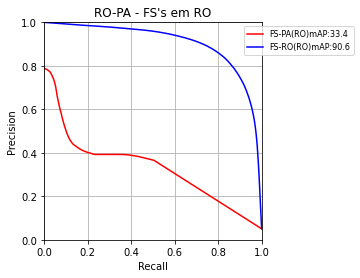

In [16]:
FS = {}
FS["PA(PA)"] = "./og_experimentos/FS/og_FS-PA(PA)/test_results/AM_PA_original_image_source_group__metrics_threshold.json"
FS["RO(RO)"] = "./og_experimentos/FS/og_FS-RO(RO)/test_results/AM_RO_original_image_source_group__metrics_threshold.json"
FS["MA(MA)"] = "./og_experimentos/FS/og_FS-MA(MA)/test_results/CE_MA_original_image_source_group__metrics_threshold.json"

FS["PA(RO)"] = "./og_experimentos/FS/og_FS-PA(RO)/test_results/AM_RO_original_image_source_group__metrics_threshold.json"
FS["PA(MA)"] = "./og_experimentos/FS/og_FS-PA(MA)/test_results/CE_MA_original_image_source_group__metrics_threshold.json"

FS["RO(PA)"] = "./og_experimentos/FS/og_FS-RO(PA)/test_results/AM_PA_original_image_source_group__metrics_threshold.json"
FS["RO(MA)"] = "./og_experimentos/FS/og_FS-RO(MA)/test_results/CE_MA_original_image_source_group__metrics_threshold.json"

FS["MA(PA)"] = "./og_experimentos/FS/og_FS-MA(PA)/test_results/AM_PA_original_image_source_group__metrics_threshold.json"
FS["MA(RO)"] = "./og_experimentos/FS/og_FS_MA(RO)/test_results/AM_RO_original_image_source_group__metrics_threshold.json"


## PA-MA
##PA
# results_folders = []
# results_folders.append(FS["MA(PA)"])
# results_folders.append(FS["PA(PA)"])
# labels = []
# labels.append("FS-MA(PA)")
# labels.append("FS-PA(PA)")
# title = "PA-MA - FS's em PA"
# file_name = "PA-MA - FS_(PA)"
# create_mAP(results_folders, labels, colors, output_path, title, file_name)
# #RO
# results_folders = []
# results_folders.append(FS["PA(MA)"])
# results_folders.append(FS["MA(MA)"])
# labels = []
# labels.append("FS-PA(MA)")
# labels.append("FS-MA(MA)")
# title = "PA-MA - FS's em MA"
# file_name = "PA-MA - FS_(MA)"
# create_mAP(results_folders, labels, colors, output_path, title, file_name)


# ## MA-RO
# #RO
# results_folders = []
# results_folders.append(FS["MA(RO)"])
# results_folders.append(FS["RO(RO)"])
# labels = []
# labels.append("FS-MA(RO)")
# labels.append("FS-RO(RO)")
# title = "MA-RO - FS's em RO"
# file_name = "MA-RO - FS_(RO)"
# create_mAP(results_folders, labels, colors, output_path, title, file_name)
# #MA
# results_folders = []
# results_folders.append(FS["RO(MA)"])
# results_folders.append(FS["MA(MA)"])
# labels = []
# labels.append("FS-RO(MA)")
# labels.append("FS-MA(MA)")
# title = "MA-RO - FS's em MA"
# file_name = "MA-RO - FS_(MA)"
# create_mAP(results_folders, labels, colors, output_path, title, file_name)


# ## RO-PA
# #PA
# results_folders = []
# results_folders.append(FS["RO(PA)"])
# results_folders.append(FS["PA(PA)"])
# labels = []
# labels.append("FS-RO(PA)")
# labels.append("FS-PA(PA)")
# title = "RO-PA - FS's em PA"
# file_name = "RO-PA - FS_(PA)"
# create_mAP(results_folders, labels, colors, output_path, title, file_name)
#RO
results_folders = []
results_folders.append(FS["PA(RO)"])
results_folders.append(FS["RO(RO)"])
labels = []
labels.append("FS-PA(RO)")
labels.append("FS-RO(RO)")
title = "RO-PA - FS's em RO"
file_name = "RO-PA - FS_(RO)"
create_mAP(results_folders, labels, colors, output_path, title, file_name)

In [25]:
# for original code
experiments_path = "./experimentos/"
output_path = "./graphs/experimentos/"
default_results_folder = "test_results"

FS = {}
FS["PA(PA)"] = "./experimentos/PA-RO_A1/test_results/AM_PA_original_image_source_group__metrics_threshold.json"
FS["RO(RO)"] = "./experimentos/PA-RO_A1/test_results/AM_RO_original_image_gt_target_group__metrics_threshold.json"
FS["MA(MA)"] = "./experimentos/sMA-tPA_A1/test_results/CE_MA_original_image_source_group__metrics_threshold.json"

FS["PA(RO)"] = "./experimentos/PA-RO_A1/test_results/AM_RO_original_image_source_group__metrics_threshold.json"
FS["PA(MA)"] = "./experimentos/sMA-tPA_A1/test_results/CE_MA_original_image_gt_target_group__metrics_threshold.json"

FS["RO(PA)"] = "./experimentos/PA-RO_A1/test_results/AM_PA_original_image_gt_target_group__metrics_threshold.json"
FS["RO(MA)"] = "./experimentos/sRO-tMA_A1/test_results/CE_MA_original_image_source_group__metrics_threshold.json"

FS["MA(PA)"] = "./experimentos/sMA-tPA_A1/test_results/AM_PA_original_image_source_group__metrics_threshold.json"
FS["MA(RO)"] = "./experimentos/sRO-tMA_A1/test_results/AM_RO_original_image_gt_target_group__metrics_threshold.json"

list_of_folders = os.listdir(experiments_path)
# print(len(list_of_folders))
# print(list_of_folders)
list_of_folders.sort()
print(list_of_folders)


# results_folders = []
# labels = []
colors = []
colors.append('#ff0000')
colors.append('#0000ff')
colors.append('#00ff00')

colors.append('#ffc0cb')
colors.append('#a52a2a')
colors.append('#000000')

# run_all(list_of_folders, colors)

['AM_PA_original_image_gt_target_group__metrics_threshold.json', 'AM_PA_original_image_source_group__metrics_threshold.json', 'AM_RO_original_image_adapted_target_group__metrics_threshold.json', 'AM_RO_original_image_gt_target_group__metrics_threshold.json', 'AM_RO_original_image_source_group__metrics_threshold.json', 'PA-RO_A1', 'PA-RO_D3']


In [ ]:
source = 'PA'
target = 'RO'
results_folders = []
labels = []
results_folders.append(FS[f"{source}({target})"])
results_folders.append(FS[f"{target}({target})"])
labels.append(f"FS_{source}({target}); ")
labels.append(f"FS_{target}({target}); ")
results_folders.append("./experimentos/PA-RO_A1/test_results/AM_RO_original_image_adapted_target_group__metrics_threshold.json")
model = f"FT_{target}-CN-T({target})"
labels.append(model + "; ")
file_name = "PA-RO_A1"
title = get_title(source, target)
create_mAP(results_folders, labels, colors, output_path, title, file_name)

source = 'MA'
target = 'PA'
results_folders = []
labels = []
results_folders.append(FS[f"{source}({target})"])
results_folders.append(FS[f"{target}({target})"])
labels.append(f"FS_{source}({target}); ")
labels.append(f"FS_{target}({target}); ")
results_folders.append("./experimentos/sMA-tPA_A1/test_results/AM_PA_original_image_adapted_target_group__metrics_threshold.json")
model = f"FT_{target}-CN-T({target})"
labels.append(model + "; ")
file_name = f"s{source}-t{target}_A1"
title = get_title(source, target)
create_mAP(results_folders, labels, colors, output_path, title, file_name)

source = 'PA'
target = 'MA'
results_folders = []
labels = []
results_folders.append(FS[f"{source}({target})"])
results_folders.append(FS[f"{target}({target})"])
labels.append(f"FS_{source}({target}); ")
labels.append(f"FS_{target}({target}); ")
results_folders.append("./experimentos/sPA-tMA_A1/test_results/CE_MA_original_image_adapted_target_group__metrics_threshold.json")
model = f"FT_{target}-CN-T({target})"
labels.append(model + "; ")
file_name = f"s{source}-t{target}_A1"
title = get_title(source, target)
create_mAP(results_folders, labels, colors, output_path, title, file_name)


source = 'RO'
target = 'MA'
results_folders = []
labels = []
results_folders.append(FS[f"{source}({target})"])
results_folders.append(FS[f"{target}({target})"])
labels.append(f"FS_{source}({target}); ")
labels.append(f"FS_{target}({target}); ")
results_folders.append("./experimentos/sRO-tMA_A1/test_results/CE_MA_original_image_adapted_target_group__metrics_threshold.json")
model = f"FT_{target}-CN-T({target})"
labels.append(model + "; ")
file_name = f"s{source}-t{target}_A1"
title = get_title(source, target)
create_mAP(results_folders, labels, colors, output_path, title, file_name)


source = 'MA'
target = 'RO'
results_folders = []
labels = []
results_folders.append(FS[f"{source}({target})"])
results_folders.append(FS[f"{target}({target})"])
labels.append(f"FS_{source}({target}); ")
labels.append(f"FS_{target}({target}); ")
results_folders.append("./experimentos/sMA-tRO_A1/test_results/AM_RO_original_image_adapted_target_group__metrics_threshold.json")
model = f"FT_{target}-CN-T({target})"
labels.append(model + "; ")
file_name = f"s{source}-t{target}_A1"
title = get_title(source, target)
create_mAP(results_folders, labels, colors, output_path, title, file_name)


# def run_all(list_of_folders, colors):
#     for i in range(len(list_of_folders)):
#         results_folders = []
#         labels = []
#         source, target, model, file_name = check_labels(list_of_folders[i])

#         results_folders.append(FS[f"{source}({target})"])
#         results_folders.append(FS[f"{target}({target})"])

#         labels.append(f"FS_{source}({target}); ")
#         labels.append(f"FS_{target}({target}); ")
#         labels.append(model + "; ")

#         path = os.path.join(experiments_path, list_of_folders[i], default_results_folder)
#         check = check_folders(path)
#         if check !=0:
#             results_folders.append(check)

#         title = get_title(source, target, model)

#         if len(results_folders) > 2:
#             create_mAP(results_folders, labels, colors, output_path, title, file_name)

In [8]:
# for og_CycleGAN (pedro)
experiments_path = "./og_experimentos/"
output_path = "./graphs/og_experimentos/"
default_results_folder = "test_results"

FS = {}
# FS["PA(PA)"] =
FS["RO(RO)"] = "./results/results_FS_RO(RO).json"
FS["MA(MA)"] = "./results/results_FS_MA(MA).json"

# FS["PA(RO)"] = 
# FS["PA(MA)"] = 

# FS["RO(PA)"] =
FS["RO(MA)"] = "./results/results_FS_RO(MA).json"

# FS["MA(PA)"] =
FS["MA(RO)"] = "./results/results_FS_MA(RO).json"

list_of_folders = os.listdir(experiments_path)
# print(len(list_of_folders))
# print(list_of_folders)
list_of_folders.sort()
print(list_of_folders)


# results_folders = []
# labels = []
colors = []
colors.append('#ff0000')
colors.append('#0000ff')
colors.append('#00ff00')

colors.append('#ffc0cb')
colors.append('#a52a2a')
colors.append('#000000')

# run_all(experiments_path, list_of_folders, colors)

['MA-RO', 'PA-MA', 'RO-PA', 'og_sMA_tRO_CTDNorm_FP', 'og_sMA_tRO_CTDNorm_FT', 'og_sMA_tRO_CTDNorm_FTP', 'og_sMA_tRO_CTDNorm_FTPF', 'og_sMA_tRO_CT_FP', 'og_sMA_tRO_CT_FT', 'og_sMA_tRO_CT_FTP', 'og_sMA_tRO_CT_FTPF', 'old', 'sMA_tRO_CYCADA_FTP']


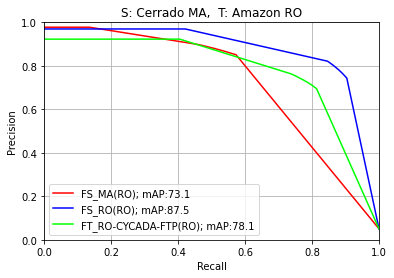

In [5]:
# source = 'MA'
# target = 'RO'
# results_folders = []
# labels = []
# results_folders.append(FS[f"{source}({target})"])
# results_folders.append(FS[f"{target}({target})"])
# labels.append(f"FS_{source}({target}); ")
# labels.append(f"FS_{target}({target}); ")
# results_folders.append("./og_experimentos/og_sMA-tRO_CD-FTP/test_results/AM_RO_original_image_adapted_target_group__metrics_threshold.json")
# model = f"FT_{target}-CD-FTP({target})"
# labels.append(model + "; ")
# file_name = f"s{source}-t{target}_CD-FTP"
# title = get_title(source, target)
# create_mAP(results_folders, labels, colors, output_path, title, file_name)

# source = 'MA'
# target = 'RO'
# results_folders = []
# labels = []
# results_folders.append(FS[f"{source}({target})"])
# results_folders.append(FS[f"{target}({target})"])
# labels.append(f"FS_{source}({target}); ")
# labels.append(f"FS_{target}({target}); ")
# results_folders.append("./og_experimentos/sMA-tRO/og_sMA_tRO_CT_FTP/test_results/AM_RO_original_image_adapted_target_group__metrics_threshold.json")
# model = f"FT_{target}-CT-FTP({target})"
# labels.append(model + "; ")
# file_name = f"s{source}-t{target}_CT-FTP"
# title = get_title(source, target)
# create_mAP(results_folders, labels, colors, output_path, title, file_name)


# source = 'MA'
# target = 'RO'
# results_folders = []
# labels = []
# results_folders.append(FS[f"{source}({target})"])
# results_folders.append(FS[f"{target}({target})"])
# labels.append(f"FS_{source}({target}); ")
# labels.append(f"FS_{target}({target}); ")
# results_folders.append("./og_experimentos/og_sMA-tRO_CN_FTP/test_results/AM_RO_original_image_adapted_target_group__metrics_threshold.json")
# model = f"FT_{target}-CN-FTP({target})"
# labels.append(model + "; ")
# file_name = f"s{source}-t{target}_CN-FTP"
# title = get_title(source, target)
# create_mAP(results_folders, labels, colors, output_path, title, file_name)

# source = 'RO'
# target = 'MA'
# results_folders = []
# labels = []
# results_folders.append(FS[f"{source}({target})"])
# results_folders.append(FS[f"{target}({target})"])
# labels.append(f"FS_{source}({target}); ")
# labels.append(f"FS_{target}({target}); ")
# results_folders.append("./og_experimentos/og_sRO-tMA_CN_FTP/test_results/CE_MA_original_image_adapted_target_group__metrics_threshold.json")
# model = f"FT_{target}-CN-FTP({target})"
# labels.append(model + "; ")
# file_name = f"s{source}-t{target}_CN-FTP"
# title = get_title(source, target)
# create_mAP(results_folders, labels, colors, output_path, title, file_name)

source = 'MA'
target = 'RO'
results_folders = []
labels = []
results_folders.append(FS[f"{source}({target})"])
results_folders.append(FS[f"{target}({target})"])
labels.append(f"FS_{source}({target}); ")
labels.append(f"FS_{target}({target}); ")
results_folders.append("./og_experimentos/sMA_tRO_CYCADA_FTP/test_results/AM_RO_original_image_adapted_target_group__metrics_threshold.json")
model = f"FT_{target}-CYCADA-FTP({target})"
labels.append(model + "; ")
file_name = f"s{source}-t{target}_CYCADA-FTP"
title = get_title(source, target)
create_mAP(results_folders, labels, colors, output_path, title, file_name)

150


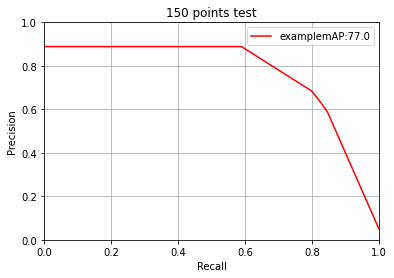

In [7]:
results_folders = []
labels = []
results_folders.append("./experimentos/PA-RO_A2/test_results/AM_RO_original_image_adapted_target_group__metrics_threshold.json")
labels.append("example")
output_path = "./graphs"
title = "150 points test"
file_name = "150_points"
create_mAP(results_folders, labels, colors, output_path, title, file_name)

In [ ]:
results_folders = ['./tmp/nada/test_results/AM_RO_original_image_adapted_target_group__metrics_threshold.json']
file_name = 'test'
output_path = './graphs/'
labels = ["sPA_tRO_CDNorm_FTP"]
title = 'sPA_tRO_CDNorm_FTP'
create_mAP(results_folders, labels, colors, output_path, title, file_name)

In [18]:
import numpy as np
min_array = np.zeros((1 , ))
print (min_array)

probs_list = np.arange(1.0, 0, -1.0/(100 - 1))
Thresholds = np.concatenate((probs_list , min_array))

# threshold_list = np.arange(1.0, 0, -1.0/(100 - 1))
# threshold_list.append(0)
# print(Thresholds)
x = "og_roy"
y = x.split("og_")[1]
print(x)
print(y == "roy")

[0.]
og_roy
True
